In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             roc_curve, precision_recall_curve, f1_score, precision_score, 
                             recall_score, auc)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/bank-additional-full.csv', sep=';')
df = df.drop_duplicates()

In [ ]:
# Feature Engineering - Handle Multicollinearity
# Drop highly correlated economic indicators (keep only euribor3m)
df = df.drop(['emp.var.rate', 'nr.employed'], axis=1)
print("Dropped emp.var.rate and nr.employed (highly correlated with euribor3m)")

Dropped emp.var.rate and nr.employed (highly correlated with euribor3m)


In [ ]:
# Separate Features and Target
X = df.drop('y', axis=1)
y = df['y'].map({'no': 0, 'yes': 1})

In [ ]:
# Encode Categorical Variables
categorical_cols = X.select_dtypes(include='object').columns.tolist()
print(f"\nCategorical columns to encode: {categorical_cols}")

# Store encoders for interpretation
le_dict = {}
X_encoded = X.copy()

for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])
    le_dict[col] = le
    print(f"{col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")


Categorical columns to encode: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
job: {'admin.': np.int64(0), 'blue-collar': np.int64(1), 'entrepreneur': np.int64(2), 'housemaid': np.int64(3), 'management': np.int64(4), 'retired': np.int64(5), 'self-employed': np.int64(6), 'services': np.int64(7), 'student': np.int64(8), 'technician': np.int64(9), 'unemployed': np.int64(10), 'unknown': np.int64(11)}
marital: {'divorced': np.int64(0), 'married': np.int64(1), 'single': np.int64(2), 'unknown': np.int64(3)}
education: {'basic.4y': np.int64(0), 'basic.6y': np.int64(1), 'basic.9y': np.int64(2), 'high.school': np.int64(3), 'illiterate': np.int64(4), 'professional.course': np.int64(5), 'university.degree': np.int64(6), 'unknown': np.int64(7)}
default: {'no': np.int64(0), 'unknown': np.int64(1), 'yes': np.int64(2)}
housing: {'no': np.int64(0), 'unknown': np.int64(1), 'yes': np.int64(2)}
loan: {'no': np.int64(0), 'unknown': np.int64(1),

In [6]:
# Cell 6: Handle Skewed Features - Log Transform
skewed_cols = ['duration', 'campaign', 'previous', 'pdays']
X_encoded_transformed = X_encoded.copy()

for col in skewed_cols:
    # Add 1 to avoid log(0)
    X_encoded_transformed[col] = np.log1p(X_encoded_transformed[col])
    print(f"Log-transformed {col}")

Log-transformed duration
Log-transformed campaign
Log-transformed previous
Log-transformed pdays


In [8]:
# Cell 7: Train-Test Split with Stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded_transformed, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)
print(f"\nTrain set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Train set conversion rate: {y_train.mean()*100:.2f}%")
print(f"Test set conversion rate: {y_test.mean()*100:.2f}%")


Train set size: 32940
Test set size: 8236
Train set conversion rate: 11.27%
Test set conversion rate: 11.27%


In [9]:
# Cell 8: Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nFeatures scaled. Mean: {X_train_scaled.mean():.4f}, Std: {X_train_scaled.std():.4f}")


Features scaled. Mean: 0.0000, Std: 1.0000


In [10]:
# Cell 9: Train Logistic Regression with Class Weight
log_reg = LogisticRegression(
    class_weight='balanced',  # Handle class imbalance
    max_iter=1000,
    random_state=42,
    solver='lbfgs'
)

log_reg.fit(X_train_scaled, y_train)
print("Logistic Regression model trained successfully!")

Logistic Regression model trained successfully!


In [11]:
# Cell 10: Make Predictions
y_train_pred = log_reg.predict(X_train_scaled)
y_train_pred_proba = log_reg.predict_proba(X_train_scaled)[:, 1]

y_test_pred = log_reg.predict(X_test_scaled)
y_test_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

In [12]:
# Cell 11: Model Evaluation - Training Set
print("\n" + "="*60)
print("TRAINING SET PERFORMANCE")
print("="*60)
print(f"Accuracy: {(y_train_pred == y_train).mean():.4f}")
print(f"Precision: {precision_score(y_train, y_train_pred):.4f}")
print(f"Recall: {recall_score(y_train, y_train_pred):.4f}")
print(f"F1-Score: {f1_score(y_train, y_train_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_train, y_train_pred_proba):.4f}")


TRAINING SET PERFORMANCE
Accuracy: 0.8414
Precision: 0.4055
Recall: 0.8758
F1-Score: 0.5544
ROC-AUC: 0.9244


In [13]:
# Cell 12: Model Evaluation - Test Set
print("\n" + "="*60)
print("TEST SET PERFORMANCE")
print("="*60)
print(f"Accuracy: {(y_test_pred == y_test).mean():.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_test_pred_proba):.4f}")

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=['No Conversion', 'Conversion']))


TEST SET PERFORMANCE
Accuracy: 0.8414
Precision: 0.4067
Recall: 0.8879
F1-Score: 0.5579
ROC-AUC: 0.9281

Classification Report (Test Set):
               precision    recall  f1-score   support

No Conversion       0.98      0.84      0.90      7308
   Conversion       0.41      0.89      0.56       928

     accuracy                           0.84      8236
    macro avg       0.69      0.86      0.73      8236
 weighted avg       0.92      0.84      0.86      8236



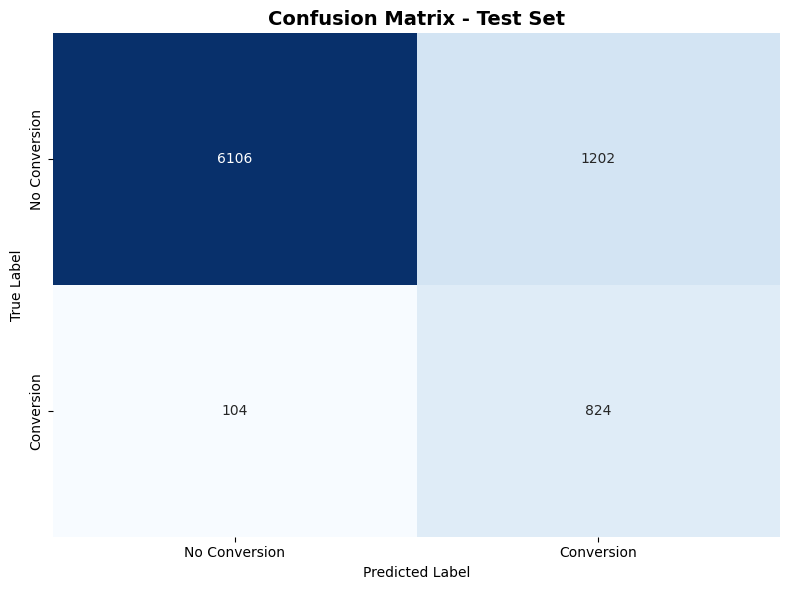

In [14]:
# Cell 13: Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Conversion', 'Conversion'],
            yticklabels=['No Conversion', 'Conversion'])
plt.title('Confusion Matrix - Test Set', fontweight='bold', fontsize=14)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

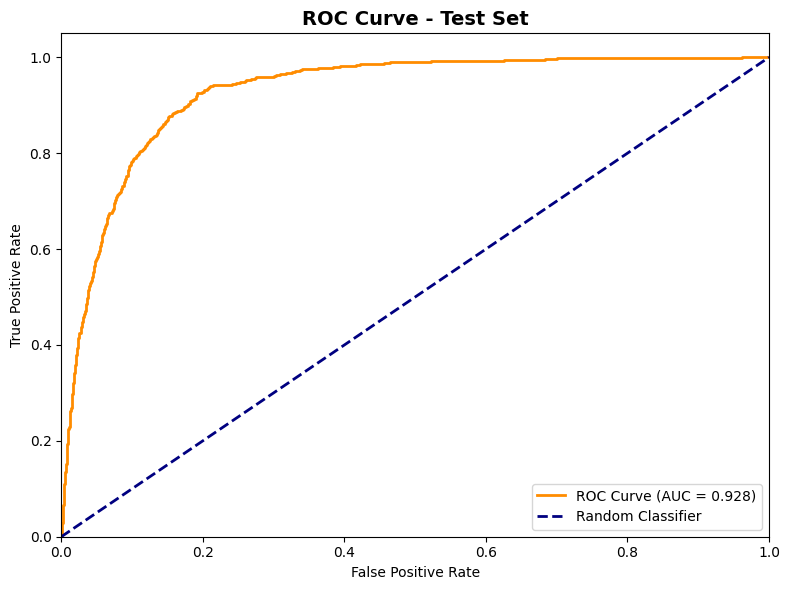

In [15]:
# Cell 14: ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set', fontweight='bold', fontsize=14)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


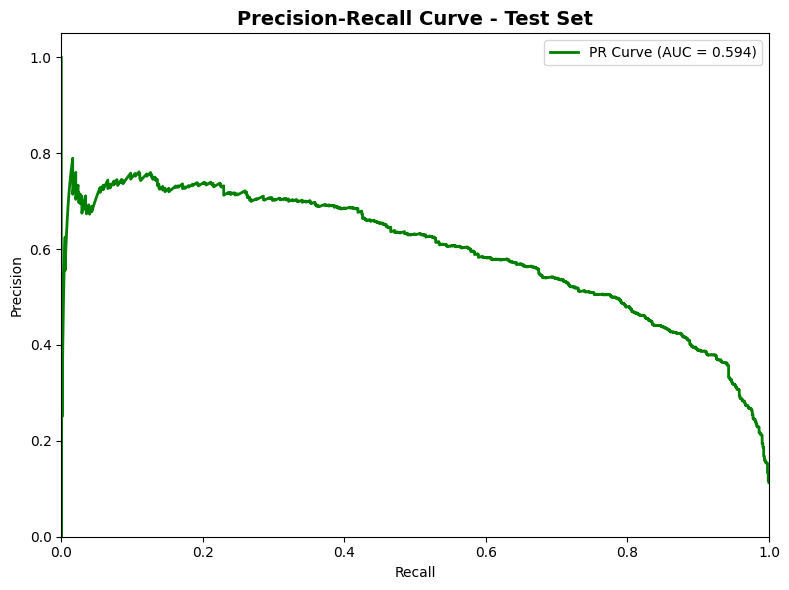

In [16]:
# Cell 15: Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_test_pred_proba)
pr_auc = auc(recall_vals, precision_vals)

plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, color='green', lw=2, label=f'PR Curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Test Set', fontweight='bold', fontsize=14)
plt.legend(loc="upper right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()

In [17]:
# Cell 16: Extract Feature Coefficients
feature_names = X_encoded.columns.tolist()
coefficients = log_reg.coef_[0]

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

print("\n" + "="*60)
print("MODEL COEFFICIENTS (Sorted by Absolute Value)")
print("="*60)
print(coef_df.to_string(index=False))

print(f"\nIntercept (Bias): {log_reg.intercept_[0]:.4f}")


MODEL COEFFICIENTS (Sorted by Absolute Value)
       Feature  Coefficient  Abs_Coefficient
      duration     2.186121         2.186121
     euribor3m    -1.384423         1.384423
 cons.conf.idx     0.337797         0.337797
         pdays    -0.297267         0.297267
cons.price.idx     0.267357         0.267357
       contact    -0.217463         0.217463
       default    -0.214201         0.214201
         month    -0.158563         0.158563
     education     0.157493         0.157493
      poutcome     0.124986         0.124986
      previous    -0.118366         0.118366
           age     0.109184         0.109184
       marital     0.105491         0.105491
      campaign    -0.090850         0.090850
           job     0.066919         0.066919
   day_of_week     0.028370         0.028370
          loan    -0.015883         0.015883
       housing     0.007759         0.007759

Intercept (Bias): -1.8274


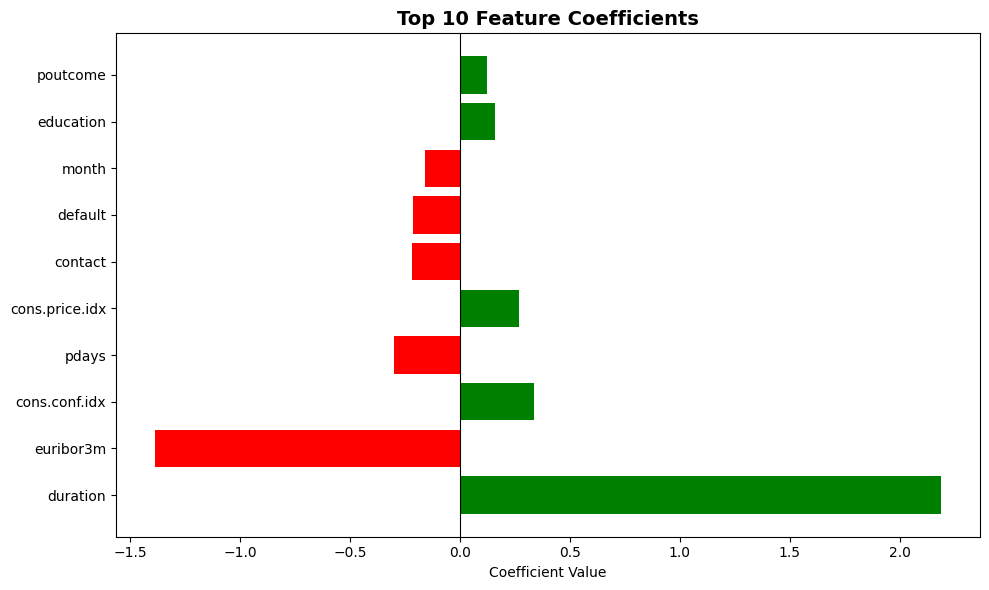

In [18]:
# Cell 17: Visualize Top 10 Features
top_n = 10
top_coef = coef_df.head(top_n)

plt.figure(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in top_coef['Coefficient']]
plt.barh(range(len(top_coef)), top_coef['Coefficient'], color=colors)
plt.yticks(range(len(top_coef)), top_coef['Feature'])
plt.xlabel('Coefficient Value')
plt.title(f'Top {top_n} Feature Coefficients', fontweight='bold', fontsize=14)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.tight_layout()
plt.show()